# Finetune Mask R-CNN with MMDetection

This notebook uses the following versions:

- `mmcv-full==1.5.0`
- `mmdet==2.24.1`
- `pycocotools==2.0.4`
- `torch==1.11.0`
- `torchvision==0.12.0+cu113`

In [1]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 24460, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24460 (delta 3), reused 11 (delta 2), pack-reused 24438
Receiving objects: 100% (24460/24460), 37.56 MiB | 36.18 MiB/s, done.
Resolving deltas: 100% (17113/17113), done.


## Step 1. Define the dataset

In [1]:
%%writefile mmdetection/mmdet/datasets/mineapple.py
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmdet.core.mask.utils import mask2bbox, encode_mask_results
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.datasets.pipelines import Compose
from PIL import Image

@DATASETS.register_module()
class MineAppleDataset(CocoDataset):
    CLASSES = ("fruit",)
    PALETTE = [(220, 20, 60)]

    def __init__(
        self,
        data_root,
        pipeline,
        classes=None,
        test_mode=False,
        filter_empty_gt=True,
        file_client_args=dict(backend='disk'),
    ):
        self.data_root = Path(data_root)
        data_dir = self.data_root / "detection"
        location = "test" if test_mode else "train"
        split_dir = data_dir / location
        self.img_prefix = split_dir / "images"
        self.seg_prefix = split_dir / "masks"
        self.test_mode = test_mode
        self.filter_empty_gt = filter_empty_gt
        self.file_client = mmcv.FileClient(**file_client_args)
        self.CLASSES = self.get_classes(classes)

        # TODO: Not sure what these are or if needed
        self.proposal_file = None
        self.proposals = None

        # Find all images and corresponding masks
        image_paths = list(sorted(self.img_prefix.glob("*.png")))
        if not image_paths:
            raise RuntimeError("No images")
        self.data_infos = []
        for image_id, image_path in enumerate(image_paths):
            width, height = Image.open(image_path).size
            data_info = {
                # TODO: id needed?
                # "id": image_id,
                "width": width,
                "height": height,
                "filename": image_path.name,
            }
            self.data_infos.append(data_info)

        # filter images too small and containing no annotations
        if not test_mode:
            # valid_inds = self._filter_imgs()
            # self.data_infos = [self.data_infos[i] for i in valid_inds]
            # set group flag for the sampler
            self._set_group_flag()

        # processing pipeline
        self.pipeline = Compose(pipeline)

    def get_ann_info(self, index):
        seg_map = self.data_infos[index]["filename"]
        int_mask = np.array(Image.open(self.seg_prefix / seg_map))

        # Convert mask from a 2D image array with objects represented by increasing
        # integers to a 3D boolean array
        # Source: https://pytorch.org/vision/stable/auto_examples/plot_repurposing_annotations.html
        object_ids = np.unique(int_mask)
        # Ignore the background object (object_id == 0)
        object_ids = object_ids[1:]
        masks = int_mask == object_ids[:, None, None]

        # Masks to boxes
        masks_good = []
        boxes = []
        for index, mask in enumerate(masks):
            y, x = np.where(mask != 0)
            box = (np.min(x), np.min(y), np.max(x), np.max(y))
            if box[2] <= box[0] or box[3] <= box[1]:
                continue
            masks_good.append(mask)
            boxes.append(box)

        # Create the object detection target in its expected format
        if boxes:
            boxes = np.array(boxes, dtype=np.float32)
        else:
            boxes = np.zeros((0, 4), dtype=np.float32)
        if masks_good:
            masks = np.array(masks_good, dtype=np.uint8)
        else:
            masks = np.zeros((0, *masks.shape[1:]), dtype=np.uint8)
        # Assume single label
        labels = np.zeros((masks.shape[0],), dtype=np.int64)
        # Assume iscrowd is always false
        bboxes_ignore = np.zeros((0, 4), dtype=np.float32)
        assert boxes.shape[0] == masks.shape[0] == labels.shape[0], (boxes.shape, masks.shape, labels.shape)
        assert labels.ndim == 1, labels.ndim
        assert bboxes_ignore.shape[0] == 0, bboxes_ignore.shape
        assert boxes.shape[1] == bboxes_ignore.shape[1] == 4, (boxes.shape, bboxes_ignore.shape)
        assert masks.shape[1:] == (1280, 720), masks.shape
        ann = {
            "bboxes": boxes,
            "labels": labels,
            "masks": masks,
            "bboxes_ignore": bboxes_ignore,
            "seg_map": seg_map,
        }
        return ann

    # def _filter_imgs(self, **kwargs):
    #     # Assume all images are valid
    #     self.img_ids = list(range(len(self.data_infos)))
    #     return self.img_ids

Writing mmdetection/mmdet/datasets/mineapple.py


In [2]:
%%writefile mmdetection/mmdet/datasets/pipelines/mineapple.py
from mmdet.core.mask.structures import BitmapMasks
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.pipelines.loading import LoadAnnotations


@PIPELINES.register_module()
class LoadMineappleAnnotations(LoadAnnotations):
    def _load_masks(self, results):
        h, w = results['img_info']['height'], results['img_info']['width']
        gt_masks = results['ann_info']['masks']
        # TODO: Maybe I can disable with_masks and do this in the dataset?...
        gt_masks = BitmapMasks(gt_masks, h, w)
        results['gt_masks'] = gt_masks
        results['mask_fields'].append('gt_masks')
        return results

Writing mmdetection/mmdet/datasets/pipelines/mineapple.py


## Step 2. Fine-tune Mask R-CNN

In [ ]:
# Setting PYTHONPATH to make custom_imports in the config work.
# Not sure if there's a better way.
!PYTHONPATH=mmdetection python mmdetection/tools/train.py fruit_detection.py

## Make COCO dataset offline

In [92]:
from pathlib import Path

from mmdet.core.mask.structures import bitmap_to_polygon
from PIL import Image

In [69]:
data_root = "data/"
test_mode = False

In [115]:
data_root = Path(data_root)

data_dir = data_root / "detection"
location = "test" if test_mode else "train"
split_dir = data_dir / location
img_prefix = split_dir / "images"
seg_prefix = split_dir / "masks"

# Find all images and corresponding masks
image_paths = list(sorted(img_prefix.glob("*.png")))
if not image_paths:
    raise RuntimeError("No images")

DEFAULT_CATEGORY_ID = 1
categories = [{"id": DEFAULT_CATEGORY_ID, "name": "fruit"}]
images, annotations = [], []
annotation_id = 1
for image_id, image_path in enumerate(image_paths):
    width, height = Image.open(image_path).size
    image = {
        "id": image_id,
        "width": width,
        "height": height,
        "file_name": image_path.name,
        # TODO
        "coco_url": None,
    }
    images.append(image)

    int_mask = np.array(Image.open(seg_prefix / image_path.name))
    # Convert mask from a 2D image array with objects represented by increasing
    # integers to a 3D boolean array
    # Source: https://pytorch.org/vision/stable/auto_examples/plot_repurposing_annotations.html
    object_ids = np.unique(int_mask)
    # Ignore the background object (object_id == 0)
    object_ids = object_ids[1:]
    masks = int_mask == object_ids[:, None, None]
    # Create individual annotations
    for index, mask in enumerate(masks):
        y, x = np.where(mask != 0)
        bbox = (np.min(x), np.min(y), np.max(x), np.max(y))
        if bbox[2] <= bbox[0] or bbox[3] <= bbox[1]:
            continue
        polygons, with_hole = bitmap_to_polygon(mask)
        assert not with_hole
        assert len(polygons) == 1
        polygon = polygons[0]
        segmentation = [polygon.ravel().tolist()]
        area = mask.sum()
        annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "segmentation": segmentation,
            "category_id": DEFAULT_CATEGORY_ID,
            "iscrowd": 0,
            "bbox": bbox,
            "area": area,
        }
        annotations.append(annotation)
        annotation_id += 1
        
dataset = {"images": images, "annotations": annotations, "categories": categories}
coco = COCO()
coco.dataset = dataset
coco.createIndex()

AssertionError: 

In [ ]:
import json

with open("mmdetection/
coco = 

In [121]:
import matplotlib.pyplot as plt

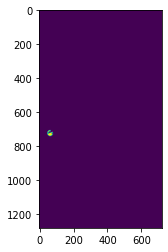

In [122]:
plt.imshow(mask)

In [117]:
polygons

[array([[ 63, 705],
        [ 62, 706],
        [ 61, 706],
        [ 60, 706],
        [ 59, 706],
        [ 58, 706],
        [ 57, 707],
        [ 56, 708],
        [ 55, 709],
        [ 54, 710],
        [ 54, 711],
        [ 53, 712],
        [ 52, 713],
        [ 51, 714],
        [ 50, 715],
        [ 50, 716],
        [ 50, 717],
        [ 50, 718],
        [ 50, 719],
        [ 50, 720],
        [ 49, 721],
        [ 49, 722],
        [ 49, 723],
        [ 49, 724],
        [ 49, 725],
        [ 49, 726],
        [ 50, 727],
        [ 50, 728],
        [ 51, 729],
        [ 51, 730],
        [ 52, 731],
        [ 52, 732],
        [ 53, 733],
        [ 53, 734],
        [ 54, 735],
        [ 55, 735],
        [ 56, 736],
        [ 57, 736],
        [ 58, 737],
        [ 59, 737],
        [ 60, 738],
        [ 61, 738],
        [ 62, 739],
        [ 63, 739],
        [ 64, 739],
        [ 65, 738],
        [ 66, 738],
        [ 67, 738],
        [ 68, 738],
        [ 69, 738],


In [98]:
polygon

([array([[149, 144],
         [148, 145],
         [147, 145],
         [146, 145],
         [145, 146],
         [144, 146],
         [143, 146],
         [142, 146],
         [141, 147],
         [140, 147],
         [140, 148],
         [139, 149],
         [139, 150],
         [139, 151],
         [139, 152],
         [138, 153],
         [138, 154],
         [138, 155],
         [138, 156],
         [137, 157],
         [137, 158],
         [137, 159],
         [137, 160],
         [138, 161],
         [138, 162],
         [139, 163],
         [139, 164],
         [139, 165],
         [140, 166],
         [140, 167],
         [141, 168],
         [141, 169],
         [142, 169],
         [143, 169],
         [144, 169],
         [145, 169],
         [146, 169],
         [147, 169],
         [148, 168],
         [149, 168],
         [150, 168],
         [151, 168],
         [152, 168],
         [153, 168],
         [154, 168],
         [155, 168],
         [156, 168],
         [156

In [ ]:
import numpy as np
import torch
from fastprogress.fastprogress import master_bar, progress_bar
from mmdet.utils import get_device
from pycocotools import mask as coco_mask

# annotation IDs need to start at 1, not 0, see torchvision issue #1530
ann_id = 1
dataset = {"images": [], "categories": [], "annotations": []}
categories = set()
mb = master_bar(range(len(ds)))
for img_idx in mb:
    mb.main_bar.comment = "images"

    data_info = ds.data_infos[img_idx]
    img_dict = {}
    img_dict["id"] = img_idx
    img_dict["height"] = data_info["height"]
    img_dict["width"] = data_info["height"]
    dataset["images"].append(img_dict)

    ann_info = ds.get_ann_info(img_idx)
    labels = ann_info["labels"].tolist()
    bboxes = ann_info["bboxes"].copy()
    bboxes[:, 2:] -= bboxes[:, :2]
    areas = bboxes[:, 2:].prod(axis=-1)
    bboxes = bboxes.tolist()
    num_objs = len(bboxes)
    iscrowd = [0] * num_objs
    if "masks" in ann_info:
        masks = ann_info["masks"]
    for i in progress_bar(range(num_objs), parent=mb):
        mb.child.comment = "annotations"
        ann = {}
        ann["image_id"] = img_idx
        ann["bbox"] = bboxes[i]
        ann["category_id"] = labels[i]
        categories.add(labels[i])
        ann["area"] = areas[i]
        ann["iscrowd"] = iscrowd[i]
        ann["id"] = ann_id
        if "masks" in ann_info:
            # NOTE: I'm not sure what this does exactly but it's needed by pycocotools.
            # TODO: Is there a way to avoid doing this on every slice?
            ann["segmentation"] = coco_mask.encode(np.asfortranarray(masks[i]))
        dataset["annotations"].append(ann)
        ann_id += 1
dataset["categories"] = [{"id": i} for i in sorted(categories)]

coco = COCO()
coco.dataset = dataset
coco.createIndex()

## Make COCO API from dataset

In [3]:
import sys

if "mmdetection" not in sys.path:
    sys.path.insert(0, "mmdetection")

In [ ]:
from mmcv import Config
from mmdet.datasets import build_dataset, build_dataloader
from mmdet.datasets.api_wrappers.coco_api import COCO
from mmdet.models import build_detector

config = "fruit_detection.py"
cfg = Config.fromfile(config)
ds = build_dataset(cfg.data.train)

import numpy as np
import torch
from fastprogress.fastprogress import master_bar, progress_bar
from mmdet.utils import get_device
from pycocotools import mask as coco_mask

device = get_device()

# annotation IDs need to start at 1, not 0, see torchvision issue #1530
ann_id = 1
dataset = {"images": [], "categories": [], "annotations": []}
categories = set()
mb = master_bar(range(len(ds)))
for img_idx in mb:
    mb.main_bar.comment = "images"

    data_info = ds.data_infos[img_idx]
    img_dict = {}
    img_dict["id"] = img_idx
    img_dict["height"] = data_info["height"]
    img_dict["width"] = data_info["height"]
    dataset["images"].append(img_dict)

    ann_info = ds.get_ann_info(img_idx)
    labels = ann_info["labels"].tolist()
    bboxes = ann_info["bboxes"].copy()
    bboxes[:, 2:] -= bboxes[:, :2]
    areas = bboxes[:, 2:].prod(axis=-1)
    bboxes = bboxes.tolist()
    num_objs = len(bboxes)
    iscrowd = [0] * num_objs
    if "masks" in ann_info:
        masks = ann_info["masks"]
    for i in progress_bar(range(num_objs), parent=mb):
        mb.child.comment = "annotations"
        ann = {}
        ann["image_id"] = img_idx
        ann["bbox"] = bboxes[i]
        ann["category_id"] = labels[i]
        categories.add(labels[i])
        ann["area"] = areas[i]
        ann["iscrowd"] = iscrowd[i]
        ann["id"] = ann_id
        if "masks" in ann_info:
            # NOTE: I'm not sure what this does exactly but it's needed by pycocotools.
            # TODO: Is there a way to avoid doing this on every slice?
            ann["segmentation"] = coco_mask.encode(np.asfortranarray(masks[i]))
        dataset["annotations"].append(ann)
        ann_id += 1
dataset["categories"] = [{"id": i} for i in sorted(categories)]

coco = COCO()
coco.dataset = dataset
coco.createIndex()

In [66]:
coco.loadImgs(0)

[{'id': 0, 'height': 1280, 'width': 1280}]

In [67]:
coco.loadAnns(1)

[{'image_id': 0,
  'bbox': [137.0, 144.0, 23.0, 25.0],
  'category_id': 0,
  'area': 575.0,
  'iscrowd': 0,
  'id': 1,
  'segmentation': {'size': [1280, 720],
   'counts': b'm\\[54hW16J7K4N2M1000000O1000O01001O2N1O2N1O2N1M4L3M4LScje0'}}]

## Step 3. Inference

In [ ]:
import sys

if "mmdetection" not in sys.path:
    sys.path.insert(0, "mmdetection")

In [ ]:
config = "fruit_detection.py"

In [ ]:
from mmcv import Config
from mmdet.datasets import build_dataset, build_dataloader
from mmdet.models import build_detector

cfg = Config.fromfile(config)
dataset = build_dataset(cfg.data.train)
model = build_detector(cfg.model)

In [26]:
len(dataset)

670

In [ ]:
from mmdet.apis import init_detector, inference_detector

model = build_detector(cfg.model)

## Rough: Train in code

In [58]:
from mmcv import Config
from mmdet.datasets import build_dataset, build_dataloader
from mmdet.models import build_detector

In [65]:
import sys
if "mmdetection" not in sys.path:
    sys.path.append("mmdetection")

['/home/jupyter/ai-playground/object-detection',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/jupyter/.ipython',
 'mmdetection']

In [74]:
config = "fruit_detection.py"

cfg = Config.fromfile(config)

args = cfg.data.train.copy()
args.pop("type")
dataset = MineAppleDataset(**args)
# datasets = [build_dataset(cfg.data.train)]

In [60]:
model = build_detector(cfg.model)

In [4]:
# Single GPU training
cfg.gpu_ids = range(1)

In [5]:
import torch.distributed as dist
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         setup_multi_processes, update_data_root)

deterministic = False
seed = 0

cfg.device = get_device()

# set random seeds
seed = init_random_seed(seed, device=cfg.device)
set_random_seed(seed, deterministic=deterministic)
cfg.seed = seed

In [6]:
distributed = False
runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner['type']
train_dataloader_default_args = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    # `num_gpus` will be ignored if distributed
    num_gpus=len(cfg["gpu_ids"]),
    dist=distributed,
    seed=cfg["seed"],
    runner_type=runner_type,
    persistent_workers=False)

train_loader_cfg = {
    **train_dataloader_default_args,
    **cfg.data.get('train_dataloader', {})
}
data_loader = build_dataloader(dataset, **train_loader_cfg)

In [7]:
import os
import time

from mmdet.apis.train import train_detector

In [8]:
no_validate = False

timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())

In [9]:
cfg.work_dir = os.path.join('./work_dirs',
                        os.path.splitext(os.path.basename(config))[0])

In [ ]:
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
meta = {
    "env_info": env_info,
    "config": cfg.pretty_text,
    "seed": cfg.seed,
    "exp_name": os.path.basename(config)
}

train_detector(model, [dataset], cfg, distributed=distributed, validate=(not no_validate), timestamp=timestamp, meta=meta)